In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.linalg import lu_factor, lu_solve
from scipy.optimize import minimize, newton

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

from tqdm import tqdm

In [2]:
def generate_gaussian(N, D, seed=0):
    np.random.seed(seed)
    X = np.random.normal(0, 1, (N, D))
    y = (np.random.normal(0, 1, N) > 0) * 2.0 - 1.0
    return X, y

def generate_gaussian_mixture(N, D, separation=1, seed=0):
    assert(N % 2 == 0)
    np.random.seed(seed)
    Xp = np.random.normal(0, 1, (N // 2, D))
    Xp[:, 0] += separation
    Xn = np.random.normal(0, 1, (N // 2, D))
    X = np.vstack((Xp, Xn))
    y = np.hstack((np.full(N // 2, 1), np.full(N // 2, -1)))
    return X, y

In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def optimize_sklearn(X, y):
    model = LogisticRegression(C=1e8, fit_intercept=False, solver='liblinear', tol=1e-8)
    model.fit(X, y)
    return model.coef_.reshape(-1)

def optimize_direct_lbfgs(X, y):
    def objective(theta):
        return -np.mean(np.log(sigmoid(y * np.dot(X, theta))))
    res = minimize(objective, np.zeros(X.shape[1]), method='L-BFGS-B', tol=1e-8)
    return res.x

def optimize_direct_bfgs(X, y):
    def objective(theta):
        return -np.mean(np.log(sigmoid(y * np.dot(X, theta))))
    res = minimize(objective, np.zeros(X.shape[1]), method='BFGS', tol=1e-8)
    return res.x

# Optimization convergence

In [4]:
X, y = generate_gaussian_mixture(1000, 200)

In [5]:
theta_1 = optimize_sklearn(X, y)

In [6]:
theta_2 = optimize_direct_lbfgs(X, y)

In [7]:
theta_3 = optimize_direct_bfgs(X, y)

In [8]:
np.linalg.norm(theta_1 - theta_2)

0.00032729305187903816

In [9]:
np.linalg.norm(theta_1 - theta_3)

3.5665034525095494e-07

In [10]:
np.linalg.norm(theta_2 - theta_3)

0.0003272120189924873

Conclusion: L-BFGS-B was a little bogus

# Training and influence prediction procedure

In [11]:
def train(X, y, indices=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient as well as the influence of selected training points.
    """
    n, d = X.shape
    theta = optimize_direct_bfgs(X, y)

    sigmoids = sigmoid(y * np.dot(X, theta))
    L_1 = -y * (1 - sigmoids)
    L_2 = sigmoids * (1 - sigmoids)
    L_3 = y * sigmoids * (1 - sigmoids) * (1 - 2 * sigmoids)

    H = np.dot(X.T * L_2, X) / n
    lu, piv = lu_factor(H)

    IF_1, IF_2 = None, None
    if indices is not None:
        EC_0 = np.sum(X[indices].T * L_1[indices], axis=1)
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1.T)
        AB_2 = np.mean(X.T * L_3 * (D_1 ** 2), axis=1)
        EC_1 = np.sum(X[indices].T * (L_2[indices] * D_1[indices]), axis=1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2

def train_external(X, y, X_infl=None, y_infl=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient as well as the influence of selected training points.
    """
    n, d = X.shape
    theta = optimize_direct_bfgs(X, y)

    sigmoids = sigmoid(y * np.dot(X, theta))
    L_1 = -y * (1 - sigmoids)
    L_2 = sigmoids * (1 - sigmoids)
    L_3 = y * sigmoids * (1 - sigmoids) * (1 - 2 * sigmoids)

    H = np.dot(X.T * L_2, X) / n
    lu, piv = lu_factor(H)
    
    IF_1, IF_2 = None, None
    if X_infl is not None and y_infl is not None:
        sigmoids_infl = sigmoid(y_infl * np.dot(X_infl, theta))
        L_infl_1 = -y_infl * (1 - sigmoids_infl)
        L_infl_2 = sigmoids_infl * (1 - sigmoids_infl)

        EC_0 = np.sum(X_infl.T * L_infl_1, axis=1)
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1.T)
        D_infl_1 = np.dot(X_infl, IF_1.T)
        AB_2 = np.mean(X.T * L_3 * (D_1 ** 2), axis=1)
        EC_1 = np.sum(X_infl.T * (L_infl_2 * D_infl_1), axis=1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2

def predict_influence(eps, grad_L_test, IF_1, IF_2):
    order_1 = np.dot(grad_L_test, IF_1) * eps
    order_2 = order_1 + np.dot(grad_L_test, IF_2) * eps * eps / 2.0
    return order_1, order_2

In [12]:
X, y = generate_gaussian(1000, 10)

In [13]:
res_1 = train(X, y, range(4), X, y)

In [14]:
res_2 = train_external(X, y, X[:4, :], y[:4], X, y)

In [15]:
np.linalg.norm(res_1[3] - res_2[3])

0.0

# Repeated points

In [16]:
def repeated_points(N, D, max_repeats=None, seed=0):
    X, y = generate_gaussian(N, D, seed)
    max_repeats = max_repeats or N

    index = np.random.choice(np.arange(N))
    orig_L_test, grad_L_test, IF_1, IF_2 = train(X, y, [index], X, y)

    I_actual, I_order_1, I_order_2 = [], [], []

    for repeats in tqdm(xrange(1, max_repeats + 1)):
        Xp = np.vstack((X, X[np.full(repeats, index)]))
        yp = np.hstack((y, y[np.full(repeats, index)]))
        L_test, _, _, _ = train(Xp, yp, None, X, y)

        eps = float(repeats) / N
        order_1, order_2 = predict_influence(eps, grad_L_test, IF_1, IF_2)

        I_actual.append(L_test - orig_L_test)
        I_order_1.append(order_1)
        I_order_2.append(order_2)

    return np.array(I_actual), np.array(I_order_1), np.array(I_order_2)

In [17]:
I_actual, I_order_1, I_order_2 = repeated_points(100, 10)

100%|██████████| 100/100 [00:01<00:00, 74.52it/s]


In [18]:
def plot_sanity(I_actual, I_order_1, I_order_2, repeats_to_show=[0]):
    bound = max(np.max(np.abs(I_actual[repeats_to_show].flatten())),
                np.max(np.abs(I_order_1[repeats_to_show].flatten())),
                np.max(np.abs(I_order_2[repeats_to_show].flatten())))
    fig = plt.figure(figsize=(15, 8))
    
    ax = plt.subplot(1, 2, 1)
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.set_ylabel('Predicted influence')
    ax.set_xlabel('Actual influence')
    ax.set_title('1st-order')
    ax.plot([-bound, bound], [-bound, bound], alpha=0.5)
    for repeats in repeats_to_show:
        ax.scatter(I_actual[repeats], I_order_1[repeats], label="{} repeats".format(repeats + 1))
    ax.legend()
    
    ax = plt.subplot(1, 2, 2)
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.set_ylabel('Predicted influence')
    ax.set_xlabel('Actual influence')
    ax.set_title('2nd-order')
    ax.plot([-bound, bound], [-bound, bound], alpha=0.5)
    for repeats in repeats_to_show:
        ax.scatter(I_actual[repeats], I_order_2[repeats], label="{} repeats".format(repeats + 1))
    ax.legend()

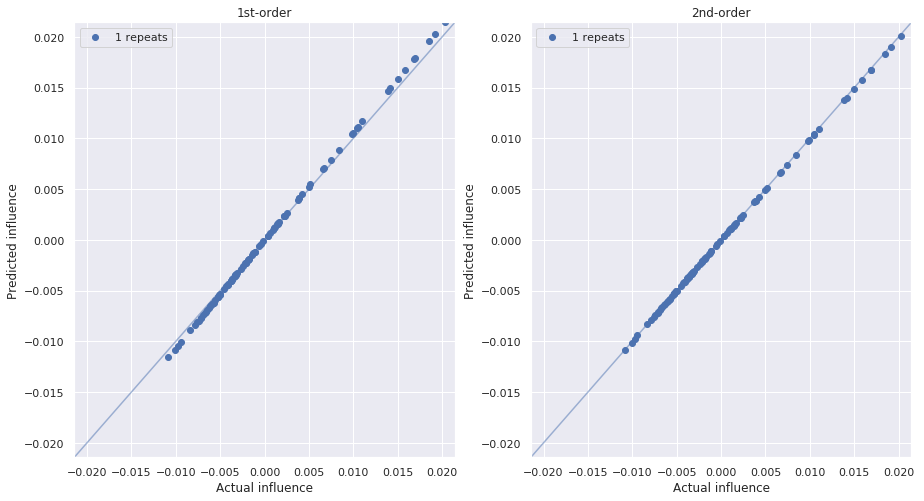

In [19]:
plot_sanity(I_actual, I_order_1, I_order_2)

So this seems right for adding the point once. More?

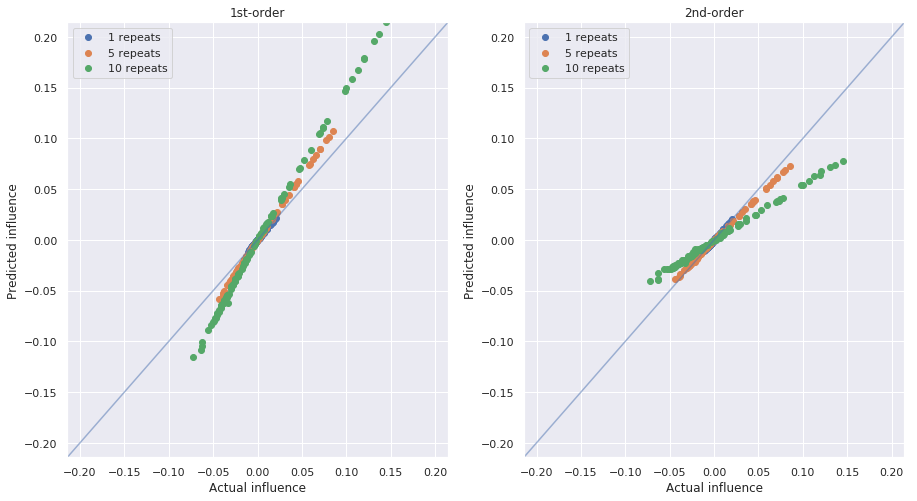

In [20]:
plot_sanity(I_actual, I_order_1, I_order_2, [0, 4, 9])

It seems like the 2nd-order influence can underestimate the actual influence!

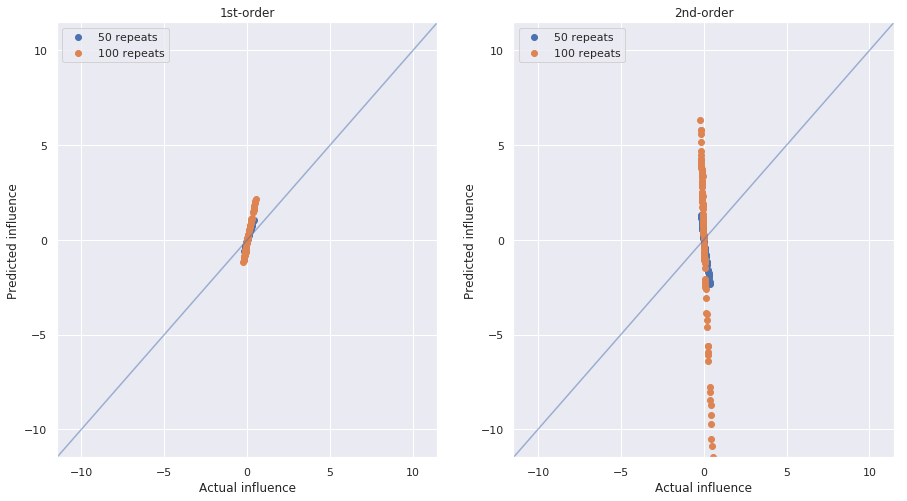

In [21]:
plot_sanity(I_actual, I_order_1, I_order_2, [49, 99])

What does this look like across repeats?

In [22]:
def plot_repeated(I_actual, I_order_1, I_order_2, num_test=10):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(1, 1, 1)

    repeats = np.arange(I_actual.shape[0]) + 1

    some_test_points = np.random.choice(np.arange(I_actual.shape[1]), size=num_test, replace=False)
    ax.set_xlabel('Copies of point')
    ax.set_ylabel('Influence')
    ax.set_title('Influence against adding repeats of a point')
    for test_point in some_test_points:
        ax.plot(repeats, I_actual[:, test_point], label="Actual influence")
        if num_test == 1:
            ax.plot(repeats, I_order_1[:, test_point], label="1st-order predicted influence")
            ax.plot(repeats, I_order_2[:, test_point], label="2nd-order predicted influence")
    if num_test == 1:
        ax.legend()

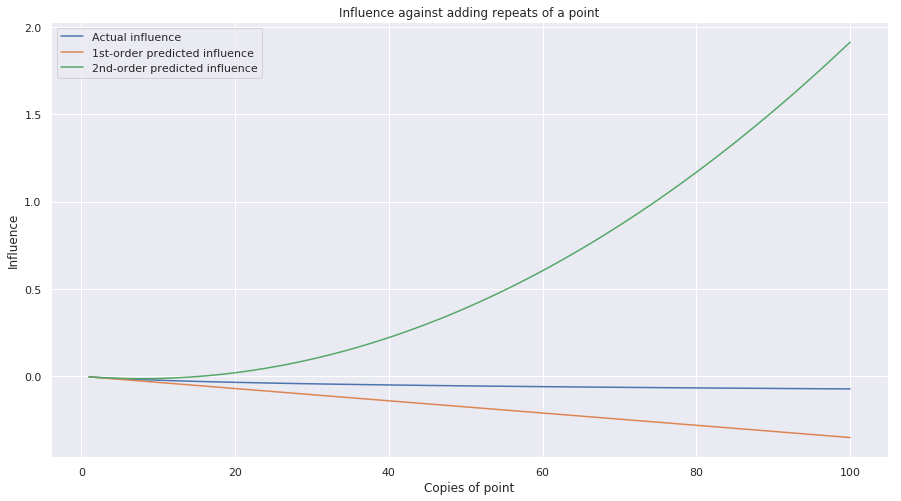

In [23]:
plot_repeated(I_actual, I_order_1, I_order_2, 1)

That's interesting. Just to make sure we are approximating the expected diminishing-returns behavior:

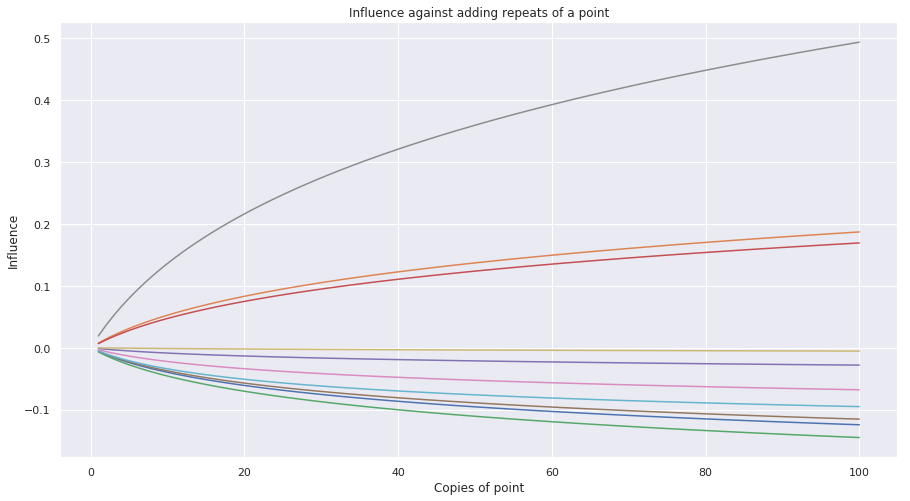

In [24]:
plot_repeated(I_actual, I_order_1, I_order_2, 10)

This looks really well-behaved.

# Dependence on overlap

In [25]:
def slowly_separate_blobs(N, D, max_separation=8, separation_samples=100):
    oX = np.random.normal(0, 1, (2 * N, D))
    y = np.hstack((np.full(N, 1), np.full(N, -1)))
    
    index = N + np.random.choice(np.arange(N)) # only within second blob

    I_actual, I_order_1, I_order_2 = [], [], []
    separations = np.linspace(0, max_separation, separation_samples)
    for separation in tqdm(separations):
        X = np.copy(oX)
        X[N:, 0] += separation
        
        orig_L_test, grad_L_test, IF_1, IF_2 = train(X, y, [index], X, y)
        
        Xp = np.vstack((X, X[index]))
        yp = np.hstack((y, y[index]))
        L_test, _, _, _ = train(Xp, yp, None, X, y)

        eps = 1.0 / (2.0 * N)
        order_1, order_2 = predict_influence(eps, grad_L_test, IF_1, IF_2)
        actual = L_test - orig_L_test

        I_actual.append(L_test - orig_L_test)
        I_order_1.append(order_1)
        I_order_2.append(order_2)

    return separations, np.array(I_actual), np.array(I_order_1), np.array(I_order_2)

In [26]:
separations, I_actual, I_order_1, I_order_2 = slowly_separate_blobs(100, 10, max_separation=5)

100%|██████████| 100/100 [00:02<00:00, 31.05it/s]


In [27]:
def plot_separation(separations, I_actual, I_order_1, I_order_2):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(1, 1, 1)

    test_point = np.random.choice(np.arange(I_actual.shape[1]))
    ax.set_xlabel('Distance between + and -')
    ax.set_ylabel('Influence')
    ax.set_title('Influence on {} against class overlap'.format(test_point))
    ax.plot(separations, I_actual[:, test_point], label="Actual influence")
    ax.plot(separations, I_order_1[:, test_point], label="1st-order predicted influence")
    ax.plot(separations, I_order_2[:, test_point], label="2nd-order predicted influence")
    ax.legend()

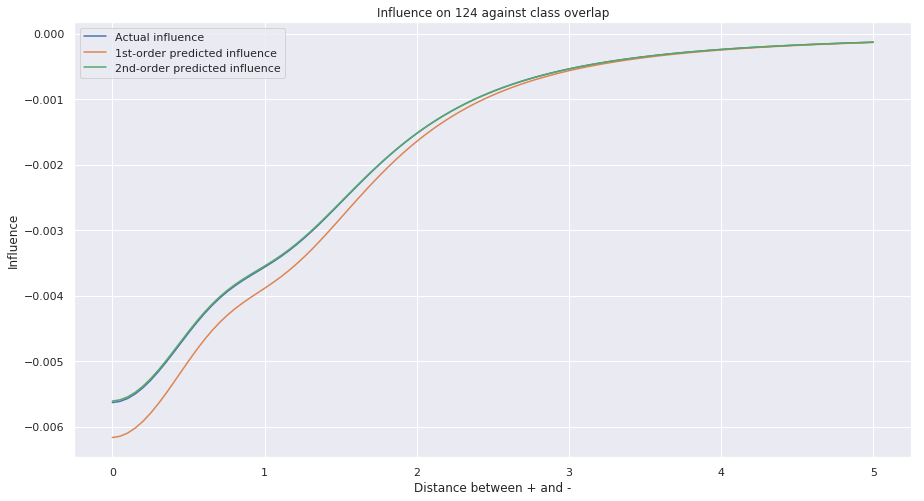

In [28]:
plot_separation(separations, I_actual, I_order_1, I_order_2)

This is odd. The 2nd-order influence does better a lot of times, but does it seem to cross the actual influence?

In [29]:
def plot_estimation(separations, I_actual, I_order_1, I_order_2):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(1, 1, 1)
    
    underestimate_1 = np.mean(np.abs(I_order_1) < np.abs(I_actual), axis=1)
    underestimate_2 = np.mean(np.abs(I_order_2) < np.abs(I_actual), axis=1)

    ax.set_xlabel('Distance between + and -')
    ax.set_ylabel('Proportion of test points')
    ax.set_title('Under/overestimation against class overlap')
    ax.plot(separations, underestimate_1, label="where abs(1st-order) < abs(actual)")
    ax.plot(separations, underestimate_2, label="where abs(2nd-order) < abs(actual)")
    ax.legend()

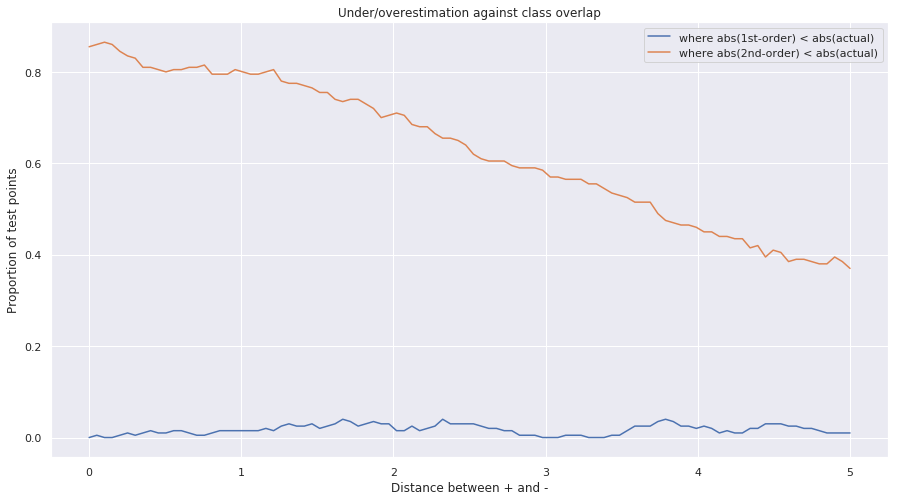

In [30]:
plot_estimation(separations, I_actual, I_order_1, I_order_2)

This doesn't quite look good. What about error?

In [31]:
def plot_error(separations, I_actual, I_order_1, I_order_2):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(1, 1, 1)
    
    error_1 = np.mean(np.abs(I_order_1 - I_actual), axis=1)
    error_2 = np.mean(np.abs(I_order_2 - I_actual), axis=1)

    ax.set_xlabel('Distance between + and -')
    ax.set_ylabel('Average estimation error')
    ax.set_title('Estimation quality against class overlap')
    ax.plot(separations, error_1, label="1st-order")
    ax.plot(separations, error_2, label="2nd-order")
    ax.legend()

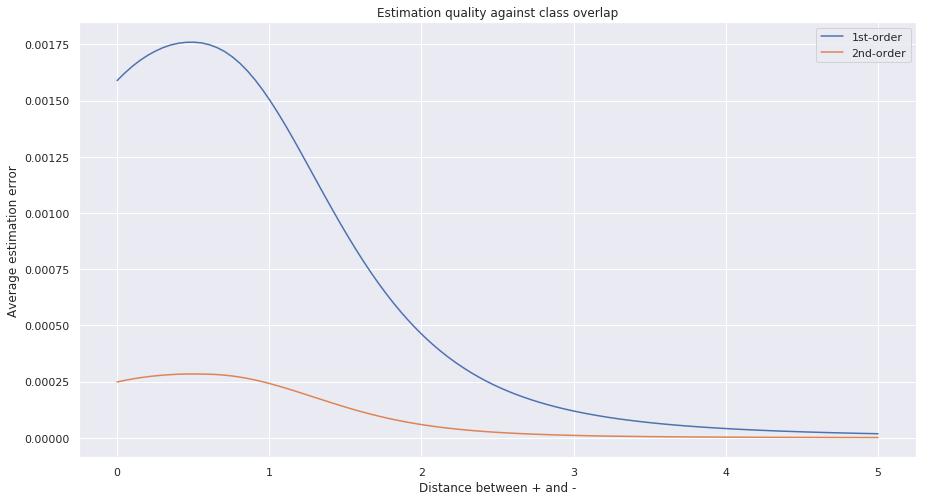

In [32]:
plot_error(separations, I_actual, I_order_1, I_order_2)

Well at least that's good.

# Dimensions

In [33]:
def different_dimensions(N, D):
    X, y = generate_gaussian(N, D)
    index = np.random.choice(np.arange(N))
    Xp = np.vstack((X, X[index]))
    yp = np.hstack((y, y[index]))
    
    I_actual, I_order_1, I_order_2 = [], [], []
    for d in tqdm(xrange(1, D + 1)):
        orig_L_test, grad_L_test, IF_1, IF_2 = train(X[:, :d], y, [index], X[:, :d], y)
        L_test, _, _, _ = train(Xp[:, :d], yp, None, X[:, :d], y)

        eps = 1.0 / N
        order_1, order_2 = predict_influence(eps, grad_L_test, IF_1, IF_2)
        actual = L_test - orig_L_test

        I_actual.append(L_test - orig_L_test)
        I_order_1.append(order_1)
        I_order_2.append(order_2)

    return np.arange(D) + 1, np.array(I_actual), np.array(I_order_1), np.array(I_order_2)

In [34]:
dimensions, I_actual, I_order_1, I_order_2 = different_dimensions(1000, 100)

100%|██████████| 100/100 [00:54<00:00,  1.08s/it]


In [35]:
def plot_dimensions(dimensions, I_actual, I_order_1, I_order_2):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(1, 1, 1)

    test_point = np.random.choice(np.arange(I_actual.shape[1]))
    ax.set_xlabel('Dimensions')
    ax.set_ylabel('Influence')
    ax.set_title('Influence on {} against dimensions'.format(test_point))
    ax.plot(dimensions, I_order_1[:, test_point] - I_actual[:, test_point], label="1st-order - actual")
    ax.plot(dimensions, I_order_2[:, test_point] - I_actual[:, test_point], label="2nd-order - actual")
    ax.legend()

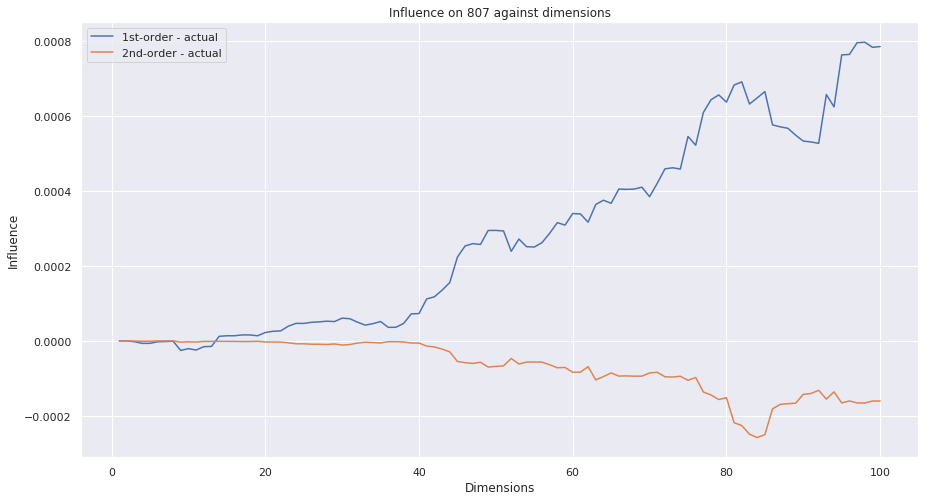

In [36]:
plot_dimensions(dimensions, I_actual, I_order_1, I_order_2)

# Representative training point

In [37]:
def find_representative(N, D, samples=100):
    X, y = generate_gaussian_mixture(N, D)
    
    # Pick two points from the same class
    i1, i2 = np.random.choice(np.arange(N // 2), 2, replace=False)
    orig_L_test, grad_L_test, IF_1, IF_2 = train(X, y, [i1, i2], X, y)
    
    # Compute their actual and predicted influence
    Xp = np.vstack((X, X[i1], X[i2]))
    yp = np.hstack((y, y[i1], y[i2]))
    L_test, _, _, _ = train(Xp, yp, None, X, y)
    separate_I_actual = L_test - orig_L_test
    separate_order_1, separate_order_2 = predict_influence(1.0 / N, grad_L_test, IF_1, IF_2)
    separate_influence = (separate_I_actual, separate_order_1, separate_order_2)
    
    # Sample points along the line between the two points, and
    # compute the influence of adding two copies of the point.
    alphas = np.linspace(0, 1, samples)
    I_actual, I_order_1, I_order_2 = [], [], []
    for alpha in tqdm(alphas):
        extra_X = X[i1] + alpha * (X[i2] - X[i1])
        extra_y = y[i1] + alpha * (y[i2] - y[i1])
        assert(extra_y == y[i1]) # the two points are from the same class
        
        _, _, IF_1, IF_2 = train_external(X, y, extra_X.reshape(1, -1), extra_y, None, None)
        order_1, order_2 = predict_influence(2.0 / N, grad_L_test, IF_1, IF_2)
        
        Xp = np.vstack((X, extra_X, extra_X))
        yp = np.hstack((y, extra_y, extra_y))
        L_test, _, _, _ = train(Xp, yp, None, X, y)
        actual = L_test - orig_L_test

        I_actual.append(L_test - orig_L_test)
        I_order_1.append(order_1)
        I_order_2.append(order_2)

    return separate_influence, alphas, np.array(I_actual), np.array(I_order_1), np.array(I_order_2)

In [79]:
separate_influence, alphas, I_actual, I_order_1, I_order_2 = find_representative(200, 10)

100%|██████████| 100/100 [00:02<00:00, 43.94it/s]


In [80]:
def find_intersection(f0, xp, fp):
    def fun(x):
        return np.interp(x, xp, fp) - f0
    return newton(fun, 0.5)

def plot_representative_sweep(separate_influence, alphas, I_actual, I_order_1, I_order_2):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(1, 1, 1)

    test_point = np.random.choice(np.arange(I_actual.shape[1]))
    sep_I_actual, sep_I_order_1, sep_I_order_2 = separate_influence
    
    alpha_actual = find_intersection(sep_I_actual[test_point], alphas, I_actual[:, test_point])
    alpha_order_1 = find_intersection(sep_I_order_1[test_point], alphas, I_order_1[:, test_point])
    alpha_order_2 = find_intersection(sep_I_order_2[test_point], alphas, I_order_2[:, test_point])
    
    ax.set_xlabel('Interpolation factor between the two training points')
    ax.set_ylabel('Influence')
    ax.set_title('Influence on {} of two copies of interpolated points'.format(test_point))
    ax.plot([0, 1], [sep_I_actual[test_point]] * 2, 'r--', label="Actual influence, separate points")
    ax.plot([0, 1], [sep_I_order_1[test_point]] * 2, 'b--', label="1st-order influence, separate points")
    ax.plot([0, 1], [sep_I_order_2[test_point]] * 2, 'g--', label="2nd-order influence, separate points")
    ax.plot(alphas, I_actual[:, test_point], 'r-', label="Actual influence")
    ax.plot(alphas, I_order_1[:, test_point], 'b-', label="1st-order influence")
    ax.plot(alphas, I_order_2[:, test_point], 'g-', label="2nd-order influence")
    ax.plot(alpha_actual, sep_I_actual[test_point], 'ro')
    ax.plot(alpha_order_1, sep_I_order_1[test_point], 'bo')
    ax.plot(alpha_order_2, sep_I_order_2[test_point], 'go')
    ax.legend()

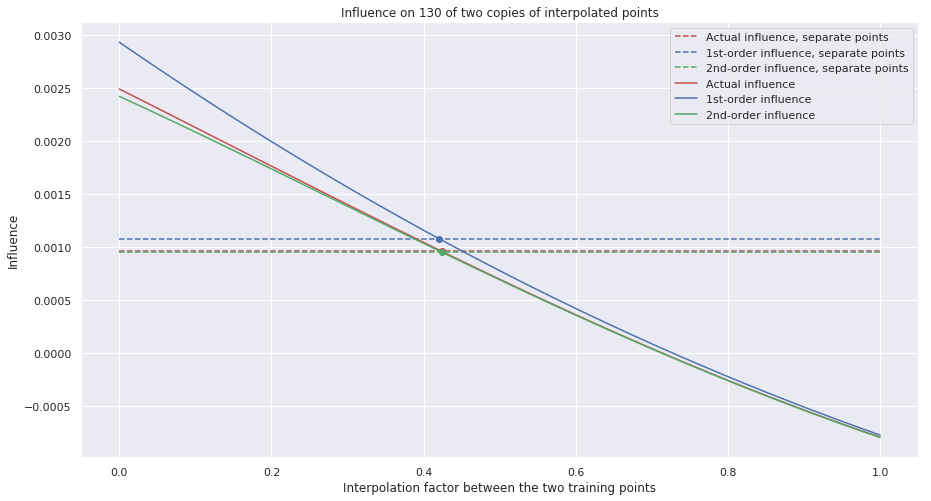

In [82]:
plot_representative_sweep(separate_influence, alphas, I_actual, I_order_1, I_order_2)

Yes, there seems to be a point between the two original training points such that adding twice of the point results in the same influence. The correct point to equalize actual, 1st-order and 2nd-order influence may not be the same, but they look quite close to each other if the 2nd-order influence is a good approximation to the actual influence. Also, this intermediate point isn't the midpoint.

In [83]:
separate_influence, alphas, I_actual, I_order_1, I_order_2 = find_representative(100, 20)

100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


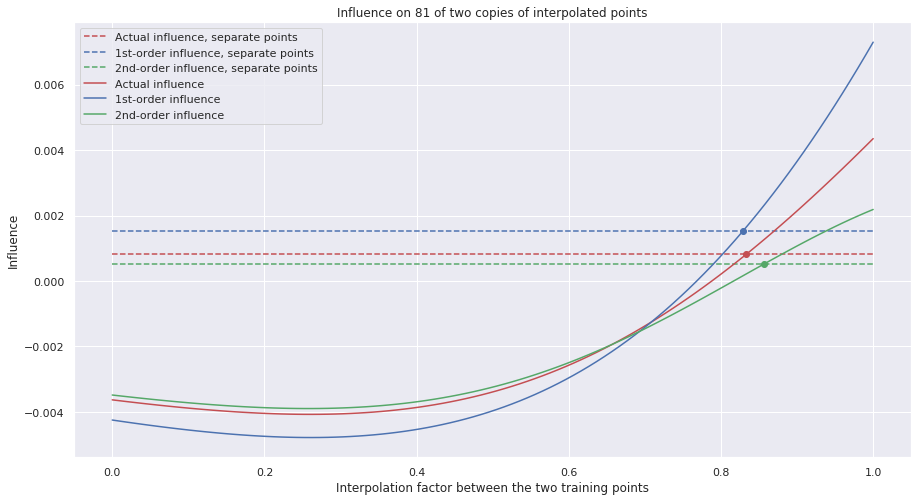

In [86]:
plot_representative_sweep(separate_influence, alphas, I_actual, I_order_1, I_order_2)

However, we can also construct a dataset such that 2nd-order influence diverges from actual influence, in which case the correct intermediate point to equalize actual and predicted influences differ.